## Importing packages

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from datetime import date
import seaborn as sns
from pydataset import data
from env import host, user, password
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import explore

## Data Dictionary 

In [3]:
# pulling data dictionary so we know what we're looking at

pd.read_csv("data_dictionary.csv")

,Unnamed: 0,type,description
0,customer_id,object,The customers unique ID
1,is_female,int64,The customers gender
2,senior_citizen,int64,"Whethe or not the customer falls under the description ""senior citizen"""
3,fam_status,object,Whether or not the customer is partnered or has children
4,tenure,int64,How many months the customer has been with Telco
5,phone_lines,object,How many phone lines the customer has
6,online_services,object,Whether or not the customer has online backup or security
7,tech_support,object,Whether or no the customer has tech support
8,streaming,object,Whether or not the customer streams movies or tv
9,contract_type_id,int64,How the customer is signed up for billing


## Acquiring data

In [4]:
# function to pull data

def get_telco_data(host = host, user = user, password = password):
    db = 'telco_churn'
    return pd.read_sql('SELECT * FROM customers JOIN internet_service_types ON (customers.internet_service_type_id = internet_service_types.internet_service_type_id)', f'mysql+pymysql://{user}:{password}@{host}/{db}')

In [5]:
# pulling the data

telco = get_telco_data()

## Cleaning and tidying

In [6]:
# function to clean data

def clean_telco(telco):
    telco.loc[(telco.phone_service == 'Yes') & (telco.multiple_lines == 'Yes'), 'phone_service'] = 'Multiple'
    telco.loc[(telco.phone_service == 'Yes') & (telco.multiple_lines == 'No'), 'phone_service'] = 'One'
    telco.loc[(telco.phone_service == 'No') & (telco.multiple_lines == 'No phone service'), 'phone_service'] = 'None'
    telco.loc[(telco.partner == 'No') & (telco.dependents == 'Yes'), 'partner'] = 'single family'
    telco.loc[(telco.partner == 'Yes') & (telco.dependents == 'Yes'), 'partner'] = 'partnered family'
    telco.loc[(telco.partner == 'Yes') & (telco.dependents == 'No'), 'partner'] = 'partnered'
    telco.loc[(telco.partner == 'No') & (telco.dependents == 'No'), 'partner'] = 'single'
    telco.loc[(telco.streaming_tv == 'No') & (telco.streaming_movies == 'No'), 'streaming_tv'] = 'None'
    telco.loc[(telco.streaming_tv == 'Yes') & (telco.streaming_movies == 'No'), 'streaming_tv'] = 'tv'
    telco.loc[(telco.streaming_tv == 'No') & (telco.streaming_movies == 'Yes'), 'streaming_tv'] = 'movies'
    telco.loc[(telco.streaming_tv == 'Yes') & (telco.streaming_movies == 'Yes'), 'streaming_tv'] = 'both'
    telco.loc[(telco.online_security == 'Yes') & (telco.online_backup == 'Yes'), 'online_security'] = 'both'
    telco.loc[(telco.online_security == 'No') & (telco.online_backup == 'Yes'), 'online_security'] = 'backup'
    telco.loc[(telco.online_security == 'Yes') & (telco.online_backup == 'No'), 'online_security'] = 'security'
    telco.loc[(telco.online_security == 'No') & (telco.online_backup == 'No'), 'online_security'] = 'None'
    telco.rename(columns={"phone_service": "phone_lines", 'online_security': 'online_services', 
                      "partner": "fam_status", 'streaming_tv': 'streaming', 'gender': 'is_female'}, inplace = True)
    telco.drop(columns = ['internet_service_type_id', 'multiple_lines', 'device_protection',
                          'dependents', 'streaming_movies', 'online_backup'], inplace = True)
    telco['years_held'] = round((telco['tenure'] / 12), 2)
    telco['churn'] = telco.churn.replace({'Yes': 1, 'No': 0})
    telco['is_female'] = telco.is_female.replace({'Female': 1, 'Male': 0})
    telco['paperless_billing'] = telco.paperless_billing.replace({'Yes': 1, 'No': 0})
    telco.total_charges = pd.to_numeric(telco.total_charges, errors='coerce').astype('float64')
    telco.total_charges = telco.total_charges.fillna(value=0)
    

### Description of clean_telco():
- Merged "phone_lines" and "multiple_lines" columns together into "phone_lines"
- Merged "partner" and "dependents" columns together into "fam_status"
- Merged "streaming_movies" and "streaming_tv" columns together into "streaming"
- Merged "online_security" and "online_backup" columns together into "online_services"
- Created a "years_held" column for the number of years a customer has been with the company
- Changed non-numeric data into numeric form
- Made "total_charges" column into valid data
- In the interest of time I'm dropping "device_protection"

In [7]:
# applying clean function to data

clean_telco(telco)

### Splitting the data

In [8]:
train, test = train_test_split(telco, test_size=.2, random_state=123, stratify=telco['churn'])
train, validate = train_test_split(train, test_size=.3, random_state=123, stratify=train['churn'])

In [9]:
train

,customer_id,is_female,senior_citizen,fam_status,tenure,phone_lines,online_services,tech_support,streaming,contract_type_id,paperless_billing,payment_type_id,monthly_charges,total_charges,churn,internet_service_type,years_held
5657,1051-EQPZR,1,0,partnered family,44,One,No internet service,No internet service,No internet service,1,0,2,19.60,780.25,0,None,3.67
3796,4450-DLLMH,0,0,single,2,One,None,No,None,1,1,4,71.30,157.75,0,Fiber optic,0.17
4566,6833-JMZYP,1,0,single,15,One,None,No,both,1,1,4,94.00,1505.45,0,Fiber optic,1.25
2389,9830-ECLEN,0,0,partnered family,58,None,both,No,tv,2,0,2,50.00,2919.85,0,DSL,4.83
2793,1200-TUZHR,1,1,single,8,Multiple,None,No,movies,1,0,1,85.20,695.75,0,Fiber optic,0.67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5295,9330-IJWIO,1,0,single,13,Multiple,security,No,both,1,1,1,100.35,1358.85,1,Fiber optic,1.08
316,1357-MVDOZ,0,0,partnered family,11,One,None,No,tv,1,1,3,59.65,683.25,0,DSL,0.92
2691,0872-NXJYS,1,0,single,9,One,None,No,movies,1,1,1,79.55,723.40,1,Fiber optic,0.75
3519,3508-CFVZL,1,0,single,71,Multiple,both,Yes,both,3,0,2,111.30,7985.90,0,Fiber optic,5.92


## Exploring

<AxesSubplot:xlabel='internet_service_type', ylabel='count'>

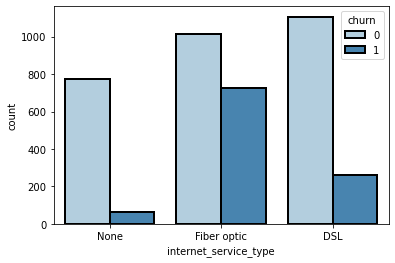

In [8]:
# plotting internet service with churn counts

sns.countplot(x = 'internet_service_type', hue = 'churn', data=train, palette='Blues', ec='black', linewidth=2)

<AxesSubplot:xlabel='senior_citizen', ylabel='count'>

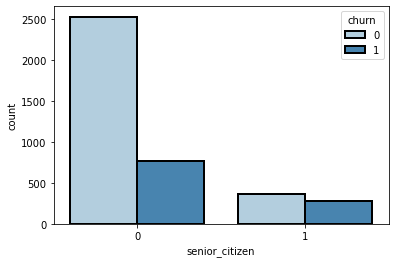

In [9]:
# plotting seniors with churn counts

sns.countplot(x = 'senior_citizen', hue = 'churn', data=train, palette='Blues', ec='black', linewidth=2)

<AxesSubplot:xlabel='fam_status', ylabel='count'>

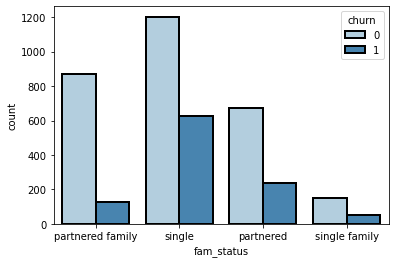

In [10]:
# plotting family types with churn counts

sns.countplot(x = 'fam_status', hue = 'churn', data=train, palette='Blues', ec='black', linewidth=2)

<AxesSubplot:xlabel='tenure', ylabel='churn'>

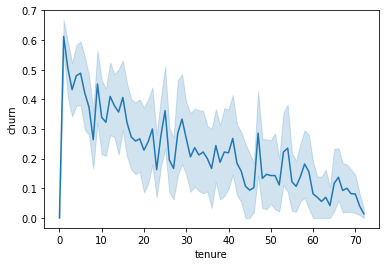

In [14]:
# plotting tenure with churn frequency

sns.lineplot(x = 'tenure', y = 'churn', data = train)

<AxesSubplot:xlabel='phone_lines', ylabel='count'>

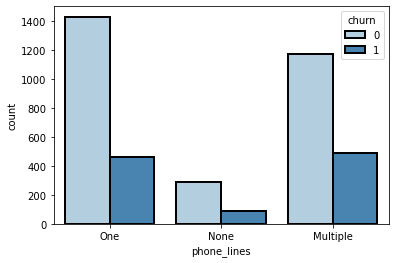

In [11]:
# plotting phone lines with churn counts

sns.countplot(x = 'phone_lines', hue = 'churn', data=train, palette='Blues', ec='black', linewidth=2)

<AxesSubplot:xlabel='is_female', ylabel='count'>

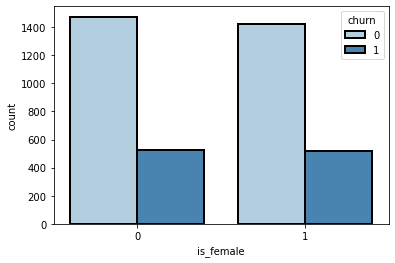

In [12]:
# plotting gender with churn counts

sns.countplot(x = 'is_female', hue = 'churn', data=train, palette='Blues', ec='black', linewidth=2)

## Univariate

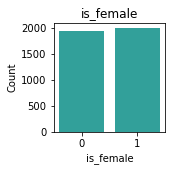

   is_female  Count  Percent
0          1   1997    50.65
1          0   1946    49.35
_________________________________________________________________


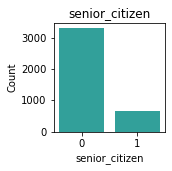

   senior_citizen  Count  Percent
0               0   3293    83.52
1               1    650    16.48
_________________________________________________________________


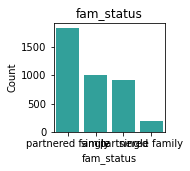

                        fam_status  Count  Percent
single            partnered family   1831    46.44
partnered family            single    999    25.34
partnered                partnered    914    23.18
single family        single family    199     5.05
_________________________________________________________________


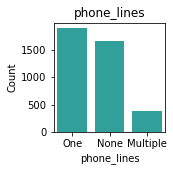

         phone_lines  Count  Percent
One              One   1896    48.09
Multiple        None   1663    42.18
None        Multiple    384     9.74
_________________________________________________________________


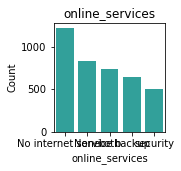

                         online_services  Count  Percent
None                 No internet service   1217    30.86
No internet service                 None    838    21.25
backup                              both    737    18.69
both                              backup    649    16.46
security                        security    502    12.73
_________________________________________________________________


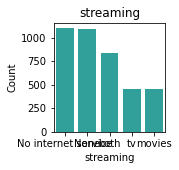

                               streaming  Count  Percent
both                 No internet service   1101    27.92
None                                None   1095    27.77
No internet service                 both    838    21.25
movies                                tv    456    11.56
tv                                movies    453    11.49
_________________________________________________________________


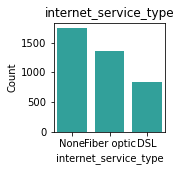

            internet_service_type  Count  Percent
Fiber optic                  None   1740    44.13
DSL                   Fiber optic   1365    34.62
None                          DSL    838    21.25
_________________________________________________________________


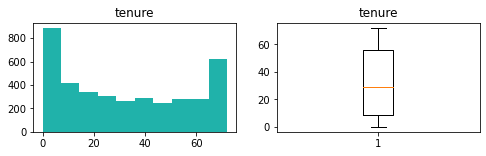

count    3943.000000
mean       32.531829
std        24.542655
min         0.000000
25%         9.000000
50%        29.000000
75%        56.000000
max        72.000000
Name: tenure, dtype: float64


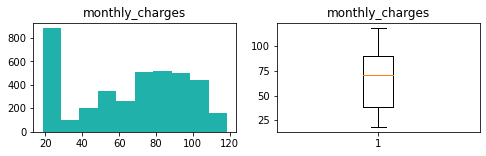

count    3943.000000
mean       65.119883
std        30.023920
min        18.400000
25%        38.175000
50%        70.600000
75%        90.050000
max       118.600000
Name: monthly_charges, dtype: float64


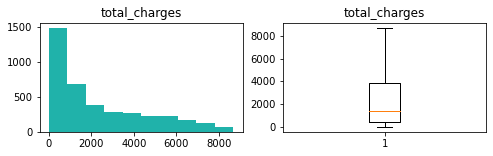

count    3943.000000
mean     2313.782425
std      2284.765985
min         0.000000
25%       402.725000
50%      1415.550000
75%      3840.675000
max      8684.800000
Name: total_charges, dtype: float64


In [13]:
# exploring univariate graphics

cat_vars = ['is_female', 'senior_citizen', 'fam_status', 'phone_lines', 'online_services',
            'streaming', 'internet_service_type']
quant_vars = ['tenure', 'monthly_charges', 'total_charges']
target = 'churn'
explore.explore_univariate(train, cat_vars, quant_vars)

## Bivariate

In [14]:
# Exploring bivariate graphics (commented out since it's hard on my poor laptop)

#explore.explore_bivariate(train, 'churn', cat_vars, quant_vars)

## Multivariate

In [15]:
# Exploring multivariate graphics (commented out since it's hard on my poor laptop)

#cat_vars = ['is_female', 'senior_citizen', 'fam_status', 'internet_service_type']
#explore.explore_multivariate(train, target, cat_vars, quant_vars)

# Statistical testing

### Hypothesis 1

#### Null Hypothesis: Churn rate is independent of internet service type
#### Alternative:  Churn rate is not independent of internet service type

In [16]:
telco_w_int = train[(train.internet_service_type != 'None')]

In [17]:
internet_churn_info = pd.crosstab(train.internet_service_type, train.churn)

In [18]:
internet_churn_info

churn,0,1
internet_service_type,,
DSL,1106,259
Fiber optic,1016,724
None,775,63


In [19]:
alpha = .05
chi2, p, degf, expected = stats.chi2_contingency(internet_churn_info)

In [20]:
print('Internet Churn Info\n')
print(internet_churn_info.values)
print('---\nExpected\n')
print(expected)
print('---\n')
print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

Internet Churn Info

[[1106  259]
 [1016  724]
 [ 775   63]]
---
Expected

[[1002.89246766  362.10753234]
 [1278.41237636  461.58762364]
 [ 615.69515597  222.30484403]]
---

chi^2 = 398.3821
p     = 0.0000


### We reject the null hypothesis that churn rate is independent of internet service type.

I can think of no reason why fiber customers have such a different churn rate than the other internet service types
other than it being related to fiber itself. Customer surveys may be helpful in this situation.

### Hypothesis 2

#### Null Hypothesis: Churn rate is independent of being a senior citizen
#### Alternative: Churn rate is not independent of being a senior citizen

In [21]:
senior_churn_info = pd.crosstab(train.senior_citizen, train.churn)

In [22]:
senior_churn_info

churn,0,1
senior_citizen,,
0,2527,766
1,370,280


In [23]:
alpha = .05
chi2, p, degf, expected = stats.chi2_contingency(senior_churn_info)

In [24]:
print('Senior Churn Info\n')
print(internet_churn_info.values)
print('---\nExpected\n')
print(expected)
print('---\n')
print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

Senior Churn Info

[[1106  259]
 [1016  724]
 [ 775   63]]
---
Expected

[[2419.43215826  873.56784174]
 [ 477.56784174  172.43215826]]
---

chi^2 = 108.3461
p     = 0.0000


### We reject the null hypothesis that churn rate is independent of being a senior citizen

Senior citizens may be churning at a higher rate because of frustration with newer technology as a whole. There is also the possibility that they may not cancel their service, but pass away and cannot continue their service. Another test is going to be performed to see if tech support makes a difference among the elderly.

### Hypothesis 3

#### Null Hypothesis: Tech support is independent of elderly churn rate
#### Alternative: Tech support is not independent of elderly churn rate

In [25]:
# Making a dataset of just elerly customers with internet

old = train[train['senior_citizen'] == 1]
old = old[old.tech_support != 'No internet service']

In [26]:
senior_tech_churn = pd.crosstab(old.tech_support, old.churn)

In [27]:
senior_tech_churn

churn,0,1
tech_support,,
No,229,248
Yes,111,30


In [28]:
alpha = .05
chi2, p, degf, expected = stats.chi2_contingency(senior_tech_churn)

In [29]:
print('Senior Tech Churn Info\n')
print(internet_churn_info.values)
print('---\nExpected\n')
print(expected)
print('---\n')
print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

Senior Tech Churn Info

[[1106  259]
 [1016  724]
 [ 775   63]]
---
Expected

[[262.42718447 214.57281553]
 [ 77.57281553  63.42718447]]
---

chi^2 = 40.2544
p     = 0.0000


### We reject the null hypothesis that tech support is independent of elderly churn rate

There is a significant difference in churn rate among the elderly who have tech support and those that do not. Those with tech support are much less likely to churn. This supports the idea that elderly persons are more likely to keep service if they are provided with tech support.

# Modeling

### Making dummies for modeling

In [30]:
def modeling_telco(telco):
    model_telco = telco
    dummies_fam = pd.get_dummies(telco[['fam_status']], drop_first = True)
    dummies_phone_lines = pd.get_dummies(telco[['phone_lines']], drop_first = True)
    dummies_online_services = pd.get_dummies(telco[['online_services']], drop_first = True)
    dummies_tech_support = pd.get_dummies(telco[['tech_support']], drop_first = True)
    dummies_streaming = pd.get_dummies(telco[['streaming']], drop_first = True)
    dummies_internet_service_type = pd.get_dummies(telco[['internet_service_type']], drop_first = True)

    model_telco.drop(columns = ['fam_status', 'phone_lines', 'online_services', 'tech_support',
                                'streaming', 'internet_service_type', 'customer_id'], inplace = True)
    model_telco = pd.concat([model_telco, dummies_fam, dummies_phone_lines, dummies_online_services,
                             dummies_tech_support, dummies_streaming, dummies_internet_service_type], axis=1)
    return model_telco

In [31]:
# applying function to get dummies

model_telco = modeling_telco(telco)

In [32]:
# splitting data again so it includes dummies

train, test = train_test_split(model_telco, test_size=.2, random_state=123, stratify=model_telco['churn'])
train, validate = train_test_split(train, test_size=.3, random_state=123, stratify=train['churn'])

In [33]:
x_train = train.drop(columns = ['churn'])
y_train = train.churn

x_validate = validate.drop(columns = ['churn'])
y_validate = validate.churn

x_test = test.drop(columns = ['churn'])
y_test = test.churn

### Baseline

In [34]:
# churn counts to establish a baseline

train.groupby('churn').count()

,is_female,senior_citizen,tenure,contract_type_id,paperless_billing,payment_type_id,monthly_charges,total_charges,years_held,fam_status_partnered family,...,online_services_both,online_services_security,tech_support_No internet service,tech_support_Yes,streaming_None,streaming_both,streaming_movies,streaming_tv,internet_service_type_Fiber optic,internet_service_type_None
churn,,,,,,,,,,,,,,,,,,,,,
0,2897,2897,2897,2897,2897,2897,2897,2897,2897,2897,...,2897,2897,2897,2897,2897,2897,2897,2897,2897,2897
1,1046,1046,1046,1046,1046,1046,1046,1046,1046,1046,...,1046,1046,1046,1046,1046,1046,1046,1046,1046,1046


In [35]:
# calculating the baseline

print(f'Baseline     = {(2897/(2897 + 1046)):.4f}')

Baseline     = 0.7347


### Function to find weights of parameters

In [36]:
def gimme_them_weights(rf, x_train):
    feat = rf.feature_importances_
    key = x_train.columns.tolist()
    val = feat.tolist()
    val = [round(num, 2) for num in val]
    res = {key[i]: val[i] for i in range(len(key))} 
    return res

## Decision Tree Model

### Max depth of 5 model

In [37]:
dt5 = DecisionTreeClassifier(max_depth=5, random_state=123)
dt5 = dt5.fit(x_train, y_train)
y5_pred = dt5.predict(x_train)

In [38]:
print(classification_report(y_train, y5_pred))

              precision    recall  f1-score   support

           0       0.85      0.89      0.87      2897
           1       0.65      0.58      0.61      1046

    accuracy                           0.81      3943
   macro avg       0.75      0.73      0.74      3943
weighted avg       0.80      0.81      0.80      3943



In [39]:
gimme_them_weights(dt5, x_train)

{'is_female': 0.0,
 'senior_citizen': 0.0,
 'tenure': 0.15,
 'contract_type_id': 0.52,
 'paperless_billing': 0.0,
 'payment_type_id': 0.03,
 'monthly_charges': 0.03,
 'total_charges': 0.06,
 'years_held': 0.02,
 'fam_status_partnered family': 0.0,
 'fam_status_single': 0.0,
 'fam_status_single family': 0.0,
 'phone_lines_None': 0.01,
 'phone_lines_One': 0.0,
 'online_services_None': 0.0,
 'online_services_backup': 0.0,
 'online_services_both': 0.0,
 'online_services_security': 0.0,
 'tech_support_No internet service': 0.02,
 'tech_support_Yes': 0.0,
 'streaming_None': 0.0,
 'streaming_both': 0.01,
 'streaming_movies': 0.0,
 'streaming_tv': 0.0,
 'internet_service_type_Fiber optic': 0.15,
 'internet_service_type_None': 0.0}

### Max depth of 4 model

In [40]:
dt4 = DecisionTreeClassifier(max_depth=4, random_state=123)
dt4 = dt4.fit(x_train, y_train)
y4_pred = dt4.predict(x_train)

In [41]:
print(classification_report(y_train, y4_pred))

              precision    recall  f1-score   support

           0       0.81      0.94      0.87      2897
           1       0.70      0.38      0.49      1046

    accuracy                           0.79      3943
   macro avg       0.75      0.66      0.68      3943
weighted avg       0.78      0.79      0.77      3943



In [42]:
gimme_them_weights(dt4, x_train)

{'is_female': 0.0,
 'senior_citizen': 0.0,
 'tenure': 0.04,
 'contract_type_id': 0.57,
 'paperless_billing': 0.0,
 'payment_type_id': 0.03,
 'monthly_charges': 0.01,
 'total_charges': 0.04,
 'years_held': 0.12,
 'fam_status_partnered family': 0.0,
 'fam_status_single': 0.0,
 'fam_status_single family': 0.0,
 'phone_lines_None': 0.01,
 'phone_lines_One': 0.0,
 'online_services_None': 0.01,
 'online_services_backup': 0.0,
 'online_services_both': 0.0,
 'online_services_security': 0.0,
 'tech_support_No internet service': 0.02,
 'tech_support_Yes': 0.0,
 'streaming_None': 0.0,
 'streaming_both': 0.0,
 'streaming_movies': 0.0,
 'streaming_tv': 0.0,
 'internet_service_type_Fiber optic': 0.16,
 'internet_service_type_None': 0.0}

## Random Forest Model

### Max depth of 5 model

In [43]:
rf5 = RandomForestClassifier(max_depth = 5, min_samples_leaf = 2, random_state=123)
rf5 = rf5.fit(x_train, y_train)
y5_pred = rf5.predict(x_train)

In [44]:
print(classification_report(y_train, y5_pred))

              precision    recall  f1-score   support

           0       0.83      0.93      0.88      2897
           1       0.72      0.48      0.58      1046

    accuracy                           0.81      3943
   macro avg       0.78      0.71      0.73      3943
weighted avg       0.80      0.81      0.80      3943



In [45]:
gimme_them_weights(rf5, x_train)

{'is_female': 0.0,
 'senior_citizen': 0.01,
 'tenure': 0.13,
 'contract_type_id': 0.17,
 'paperless_billing': 0.01,
 'payment_type_id': 0.07,
 'monthly_charges': 0.09,
 'total_charges': 0.06,
 'years_held': 0.16,
 'fam_status_partnered family': 0.01,
 'fam_status_single': 0.0,
 'fam_status_single family': 0.0,
 'phone_lines_None': 0.0,
 'phone_lines_One': 0.01,
 'online_services_None': 0.08,
 'online_services_backup': 0.01,
 'online_services_both': 0.01,
 'online_services_security': 0.0,
 'tech_support_No internet service': 0.02,
 'tech_support_Yes': 0.01,
 'streaming_None': 0.0,
 'streaming_both': 0.0,
 'streaming_movies': 0.0,
 'streaming_tv': 0.0,
 'internet_service_type_Fiber optic': 0.09,
 'internet_service_type_None': 0.03}

### Max depth of 10 model

In [46]:
rf10 = RandomForestClassifier(max_depth = 10, min_samples_leaf = 2, random_state=123)
rf10 = rf10.fit(x_train, y_train)
y10_pred = rf10.predict(x_train)

In [47]:
print(classification_report(y_train, y10_pred))

              precision    recall  f1-score   support

           0       0.89      0.96      0.92      2897
           1       0.86      0.68      0.76      1046

    accuracy                           0.89      3943
   macro avg       0.87      0.82      0.84      3943
weighted avg       0.88      0.89      0.88      3943



In [48]:
gimme_them_weights(rf10, x_train)

{'is_female': 0.02,
 'senior_citizen': 0.02,
 'tenure': 0.12,
 'contract_type_id': 0.11,
 'paperless_billing': 0.02,
 'payment_type_id': 0.06,
 'monthly_charges': 0.13,
 'total_charges': 0.12,
 'years_held': 0.13,
 'fam_status_partnered family': 0.01,
 'fam_status_single': 0.01,
 'fam_status_single family': 0.0,
 'phone_lines_None': 0.01,
 'phone_lines_One': 0.02,
 'online_services_None': 0.05,
 'online_services_backup': 0.01,
 'online_services_both': 0.01,
 'online_services_security': 0.01,
 'tech_support_No internet service': 0.01,
 'tech_support_Yes': 0.02,
 'streaming_None': 0.01,
 'streaming_both': 0.01,
 'streaming_movies': 0.01,
 'streaming_tv': 0.01,
 'internet_service_type_Fiber optic': 0.06,
 'internet_service_type_None': 0.02}

### Max depth of 15 model

In [49]:
rf15 = RandomForestClassifier(max_depth = 10, min_samples_leaf = 2, random_state=123)
rf15 = rf15.fit(x_train, y_train)
y15_pred = rf15.predict(x_train)

In [50]:
print(classification_report(y_train, y15_pred))

              precision    recall  f1-score   support

           0       0.89      0.96      0.92      2897
           1       0.86      0.68      0.76      1046

    accuracy                           0.89      3943
   macro avg       0.87      0.82      0.84      3943
weighted avg       0.88      0.89      0.88      3943



In [51]:
gimme_them_weights(rf15, x_train)

{'is_female': 0.02,
 'senior_citizen': 0.02,
 'tenure': 0.12,
 'contract_type_id': 0.11,
 'paperless_billing': 0.02,
 'payment_type_id': 0.06,
 'monthly_charges': 0.13,
 'total_charges': 0.12,
 'years_held': 0.13,
 'fam_status_partnered family': 0.01,
 'fam_status_single': 0.01,
 'fam_status_single family': 0.0,
 'phone_lines_None': 0.01,
 'phone_lines_One': 0.02,
 'online_services_None': 0.05,
 'online_services_backup': 0.01,
 'online_services_both': 0.01,
 'online_services_security': 0.01,
 'tech_support_No internet service': 0.01,
 'tech_support_Yes': 0.02,
 'streaming_None': 0.01,
 'streaming_both': 0.01,
 'streaming_movies': 0.01,
 'streaming_tv': 0.01,
 'internet_service_type_Fiber optic': 0.06,
 'internet_service_type_None': 0.02}

## KNN Model

### 5 neighbor model

In [52]:
kn = KNeighborsClassifier(n_neighbors=5, weights='uniform')
kn = kn.fit(x_train, y_train)
kn_pred = kn.predict(x_train)

In [53]:
print(classification_report(y_train, kn_pred))

              precision    recall  f1-score   support

           0       0.85      0.93      0.89      2897
           1       0.73      0.56      0.63      1046

    accuracy                           0.83      3943
   macro avg       0.79      0.74      0.76      3943
weighted avg       0.82      0.83      0.82      3943



### 10 neighbor model

In [54]:
kn10 = KNeighborsClassifier(n_neighbors=10, weights='uniform')
kn10 = kn10.fit(x_train, y_train)
kn10_pred = kn10.predict(x_train)

In [55]:
print(classification_report(y_train, kn10_pred))

              precision    recall  f1-score   support

           0       0.82      0.95      0.88      2897
           1       0.75      0.41      0.53      1046

    accuracy                           0.81      3943
   macro avg       0.79      0.68      0.71      3943
weighted avg       0.80      0.81      0.79      3943



## Logistic Regression Model

### Function to find coefficients for logistic regression

In [56]:
def gimme_them_coef(logit2, x_train):
    feat = logit2.coef_[0]
    key = x_train.columns.tolist()
    val = feat.tolist()
    val = [round(num, 2) for num in val]
    res = {key[i]: val[i] for i in range(len(key))} 
    return res

### C = 10 model

In [57]:
logit2 = LogisticRegression(C=10, random_state=123)
logit2 = logit2.fit(x_train, y_train)
y_predict = logit2.predict(x_train)

/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [58]:
print(classification_report(y_train, y_predict))

              precision    recall  f1-score   support

           0       0.85      0.90      0.87      2897
           1       0.66      0.54      0.60      1046

    accuracy                           0.81      3943
   macro avg       0.75      0.72      0.73      3943
weighted avg       0.80      0.81      0.80      3943



In [59]:
gimme_them_coef(logit2, x_train)

{'is_female': 0.03,
 'senior_citizen': 0.31,
 'tenure': -0.06,
 'contract_type_id': -0.67,
 'paperless_billing': 0.35,
 'payment_type_id': -0.14,
 'monthly_charges': 0.01,
 'total_charges': 0.0,
 'years_held': -0.01,
 'fam_status_partnered family': -0.21,
 'fam_status_single': 0.04,
 'fam_status_single family': -0.01,
 'phone_lines_None': 0.2,
 'phone_lines_One': -0.34,
 'online_services_None': 0.32,
 'online_services_backup': 0.12,
 'online_services_both': -0.23,
 'online_services_security': -0.13,
 'tech_support_No internet service': -0.14,
 'tech_support_Yes': -0.34,
 'streaming_None': 0.04,
 'streaming_both': 0.1,
 'streaming_movies': -0.06,
 'streaming_tv': 0.0,
 'internet_service_type_Fiber optic': 0.28,
 'internet_service_type_None': -0.14}

### C = 100 model

In [60]:
logit2 = LogisticRegression(C=100, random_state=123)
logit2 = logit2.fit(x_train, y_train)
y_predict = logit2.predict(x_train)

In [61]:
print(classification_report(y_train, y_predict))

              precision    recall  f1-score   support

           0       0.84      0.90      0.87      2897
           1       0.66      0.53      0.59      1046

    accuracy                           0.80      3943
   macro avg       0.75      0.72      0.73      3943
weighted avg       0.79      0.80      0.80      3943



## Validate

### Decision tree depth = 5

In [62]:
y5_val_pred = dt5.predict(x_validate)
print(classification_report(y_validate, y5_val_pred))

              precision    recall  f1-score   support

           0       0.85      0.87      0.86      1242
           1       0.62      0.56      0.59       449

    accuracy                           0.79      1691
   macro avg       0.73      0.72      0.73      1691
weighted avg       0.79      0.79      0.79      1691



### Random forest depth = 10

In [63]:
y10_val_pred = rf10.predict(x_validate)
print(classification_report(y_validate, y10_val_pred))

              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1242
           1       0.67      0.49      0.57       449

    accuracy                           0.80      1691
   macro avg       0.75      0.70      0.72      1691
weighted avg       0.79      0.80      0.79      1691



### KNN 5 neighbor

In [64]:
kn_val_pred = kn.predict(x_validate)
print(classification_report(y_validate, kn_val_pred))

              precision    recall  f1-score   support

           0       0.81      0.88      0.84      1242
           1       0.56      0.42      0.48       449

    accuracy                           0.76      1691
   macro avg       0.68      0.65      0.66      1691
weighted avg       0.74      0.76      0.75      1691



# Test

I have decided to run the random forest with a max depth of 10 as it seems to have the best evaluation metrics

In [65]:
y10_test_pred = rf10.predict(x_test)
print(classification_report(y_test, y10_test_pred))

              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1035
           1       0.67      0.52      0.58       374

    accuracy                           0.80      1409
   macro avg       0.75      0.71      0.73      1409
weighted avg       0.79      0.80      0.79      1409



When compared to the baseline this model is not a lot better, but has some value in predicting churn.

# Making a prediction.csv

In [66]:
y10_proba = rf10.predict_proba(model_telco.drop(columns = ['churn']))

In [67]:
y10_pred = rf10.predict(model_telco.drop(columns = ['churn']))

In [68]:
y10_pred = pd.DataFrame(y10_pred)

In [69]:
y10_proba = pd.DataFrame(y10_proba)

In [70]:
customers = model_telco['customer_id']

KeyError: 'customer_id'

In [ ]:
bleh = pd.concat([customers, y10_proba, y10_pred], axis = 1)

In [ ]:
bleh.drop(bleh.columns[1], axis=1, inplace = True)

In [ ]:
bleh = pd.concat([bleh, y10_pred], axis = 1)

In [ ]:
bleh.rename(columns = {0: 'prediction'}, inplace = True)

In [ ]:
bleh.rename(columns = {1: 'probability'}, inplace = True)

In [ ]:
# bleh.to_csv("predictions.csv")

## Data dictionary making

In [74]:
telco = get_telco_data()
clean_telco(telco)

In [90]:
data_dictionary = pd.DataFrame(index = telco.columns, columns=['type', 'description'])
for name in telco.columns:
    data_dictionary.loc[name,'type'] = 'object'

In [94]:
data_dictionary.loc[['is_female', 'senior_citizen', 'tenure', 'contract_type_id', 'paperless_billing',
                     'payment_type_id', 'churn'], 'type'] = 'int64'
data_dictionary.loc[['monthly_charges', 'total_charges', 'years_held'], 'type'] = 'float64'

In [95]:
telco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   customer_id            7043 non-null   object 
 1   is_female              7043 non-null   int64  
 2   senior_citizen         7043 non-null   int64  
 3   fam_status             7043 non-null   object 
 4   tenure                 7043 non-null   int64  
 5   phone_lines            7043 non-null   object 
 6   online_services        7043 non-null   object 
 7   tech_support           7043 non-null   object 
 8   streaming              7043 non-null   object 
 9   contract_type_id       7043 non-null   int64  
 10  paperless_billing      7043 non-null   int64  
 11  payment_type_id        7043 non-null   int64  
 12  monthly_charges        7043 non-null   float64
 13  total_charges          7043 non-null   float64
 14  churn                  7043 non-null   int64  
 15  inte

In [101]:
data_dictionary

,type,description
customer_id,object,The customers unique ID
is_female,int64,The customers gender
senior_citizen,int64,"Whethe or not the customer falls under the description ""senior citizen"""
fam_status,object,Whether or not the customer is partnered or has children
tenure,int64,How many months the customer has been with Telco
phone_lines,object,How many phone lines the customer has
online_services,object,Whether or not the customer has online backup or security
tech_support,object,Whether or no the customer has tech support
streaming,object,Whether or not the customer streams movies or tv
contract_type_id,int64,How the customer is signed up for billing


In [100]:
data_dictionary.loc[['customer_id'], 'description'] = 'The customers unique ID'
data_dictionary.loc[['is_female'], 'description'] = 'The customers gender'
data_dictionary.loc[['senior_citizen'], 'description'] = 'Whethe or not the customer falls under the description \"senior citizen\"'
data_dictionary.loc[['fam_status'], 'description'] = 'Whether or not the customer is partnered or has children'
data_dictionary.loc[['tenure'], 'description'] = 'How many months the customer has been with Telco'
data_dictionary.loc[['phone_lines'], 'description'] = 'How many phone lines the customer has'
data_dictionary.loc[['online_services'], 'description'] = 'Whether or not the customer has online backup or security'
data_dictionary.loc[['tech_support'], 'description'] = 'Whether or no the customer has tech support'
data_dictionary.loc[['streaming'], 'description'] = 'Whether or not the customer streams movies or tv'
data_dictionary.loc[['contract_type_id'], 'description'] = 'How the customer is signed up for billing'
data_dictionary.loc[['paperless_billing'], 'description'] = 'Whether the customer is mailed bills or not'
data_dictionary.loc[['payment_type_id'], 'description'] = 'How the customer pays their bill'
data_dictionary.loc[['monthly_charges'], 'description'] = 'How much the customer is charged per month'
data_dictionary.loc[['total_charges'], 'description'] = 'Total charges during the customers time with Telco'
data_dictionary.loc[['churn'], 'description'] = 'Whether the customer is still with Telco or not'
data_dictionary.loc[['internet_service_type'], 'description'] = 'Whether the customer has Fiber, DSL, or no internet'
data_dictionary.loc[['years_held'], 'description'] = 'Years the customer has been with Telco'

In [106]:
print(data_dictionary.to_markdown())

|                       | type    | description                                                             |
|:----------------------|:--------|:------------------------------------------------------------------------|
| customer_id           | object  | The customers unique ID                                                 |
| is_female             | int64   | The customers gender                                                    |
| senior_citizen        | int64   | Whethe or not the customer falls under the description "senior citizen" |
| fam_status            | object  | Whether or not the customer is partnered or has children                |
| tenure                | int64   | How many months the customer has been with Telco                        |
| phone_lines           | object  | How many phone lines the customer has                                   |
| online_services       | object  | Whether or not the customer has online backup or security               |
| tech_sup